<a href="https://colab.research.google.com/github/JumanaWanass/Star-Classification/blob/main/Star_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [200]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
f1_score, confusion_matrix, ConfusionMatrixDisplay)

Data preparing

In [201]:
colNames = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
            'Absolute magnitude(Mv)', 'Star color', 'Spectral Class', 'Star type']
df = pd.read_csv('StarType.csv', skiprows=1, names=colNames)


In [202]:
class_mapping = {
    0: 'Red Dwarf',
    1: 'Brown Dwarf',
    2: 'White Dwarf',
    3: 'Main Sequence',
    4: 'Supergiant',
    5: 'Hypergiant'
}

df['Star type'] = df['Star type'].map(class_mapping)


Removing outliers

In [203]:
# Calculate the IQR for all numerical columns
Q1 = df.select_dtypes(include=[np.number]).quantile(0.25)
Q3 = df.select_dtypes(include=[np.number]).quantile(0.75)
IQR = Q3 - Q1

# Define a multiplier for IQR
iqr_multiplier = 1.5

# Create a mask to identify rows with outliers in any feature
outlier_mask = ((df.select_dtypes(include=[np.number]) < (Q1 - iqr_multiplier * IQR)) |
                (df.select_dtypes(include=[np.number]) >
                 (Q3 + iqr_multiplier * IQR))).any(axis=1)

# Remove rows with outliers
df_clean = df[~outlier_mask]
df.describe()


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


Convert string values to int

In [204]:
encoder = OneHotEncoder(sparse=False, drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(df[['Star color', 'Spectral Class']]))

# Drop the original categorical columns and concatenate the encoded columns
df = df.drop(columns=['Star color', 'Spectral Class'])
X = pd.concat([df, X_encoded], axis=1)

# Define your features (X) and target variable (y)
X = X.drop(columns=['Star type'])  # Features (all columns except 'Star type')
y = df['Star type']  # Target variable ('Star type' column)

# Convert feature column names to strings (if not already)
X.columns = X.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [205]:

# Split the data into a train set and a test set (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X.columns = X.columns.astype(str)



Using weighted KNN

In [206]:
# Train and evaluate KNN model with weights

# Define parameter grid for KNN
knn_param_grid = {'n_neighbors': range(3, 15, 2)}

# Create a list of weights to test (you can adjust this as needed)
weights_to_test = ['uniform', 'distance']

best_knn_weighted = None
best_knn_weighted_accuracy = 0

# Iterate over different weight options
for weight_option in weights_to_test:
    knn_grid = GridSearchCV(KNeighborsClassifier(weights=weight_option),
                            knn_param_grid, cv=3)
    knn_grid.fit(X_train, y_train)

    # Get the best KNN model for this weight option
    bestKnn = knn_grid.best_estimator_

    # Train the best KNN model
    bestKnn.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = bestKnn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Check if this model has better accuracy
    if accuracy > best_knn_weighted_accuracy:
        best_knn_weighted_accuracy = accuracy
        best_knn_weighted = bestKnn

# Print the best weighted KNN classifier
print("Best Weighted KNN Classifier:", best_knn_weighted)
print("Accuracy of Best Weighted KNN:", best_knn_weighted_accuracy)


Best Weighted KNN Classifier: KNeighborsClassifier(n_neighbors=3, weights='distance')
Accuracy of Best Weighted KNN: 0.75


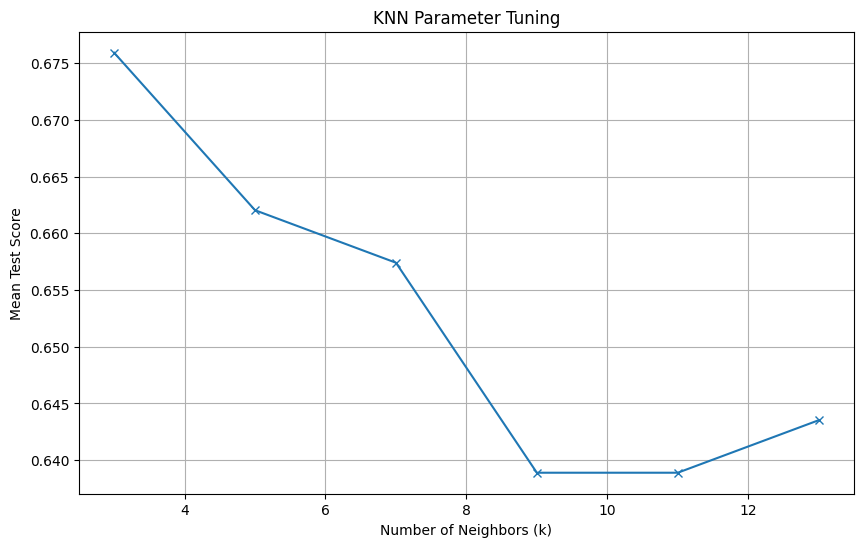

Best Knn Classifier:  KNeighborsClassifier(n_neighbors=3, weights='distance')


In [207]:
k_values = knn_param_grid['n_neighbors']
mean_test_scores = knn_grid.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_test_scores, marker='x')
plt.title('KNN Parameter Tuning')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()
print("Best Knn Classifier: ", knn_grid.best_estimator_)

In [208]:
# Train the best KNN model
bestKnn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bestKnn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.75


Using Adaboost

In [209]:
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    random_state=42  # Set a random seed for reproducibility
)


In [210]:
# Define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of weak learners (iterations)
    'learning_rate': [0.1, 0.5, 1.0]  # Learning rate (adjust as needed)
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(
    estimator=adaboost_model,  # Use 'estimator' instead of 'base_estimator'
    param_grid=param_grid,
    cv=3,  # Number of cross-validation folds
    scoring='accuracy'  # Evaluation metric (you can use other metrics)
)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best estimator (model) with optimal hyperparameters
best_adaboost_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model using cross-validation
cross_val_scores = cross_val_score(best_adaboost_model, X_train, y_train, cv=5)  # You can adjust the number of folds
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

# Fit the best model to your full training data (optional)
best_adaboost_model.fit(X_train, y_train)

# Make predictions on your test data
y_pred = best_adaboost_model.predict(X_test)

Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 50}
Cross-Validation Scores: [1.         0.97674419 1.         1.         1.        ]
Mean Cross-Validation Score: 0.9953488372093023


In [211]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: " , accuracy)

Accuracy:  1.0
